In [306]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

tf.random.set_seed(2)

In [307]:
hr = pd.read_csv("/Users/dominicventura/Machine Learning/Neural Network Project/hremployee.csv")

In [308]:
hr.shape

(1470, 35)

In [309]:
hr['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

There is a massive imbalance in attrition. About 84% (1,233/1,470) of the employees didn't leave while the other 16% (237/1,470) did leave. 

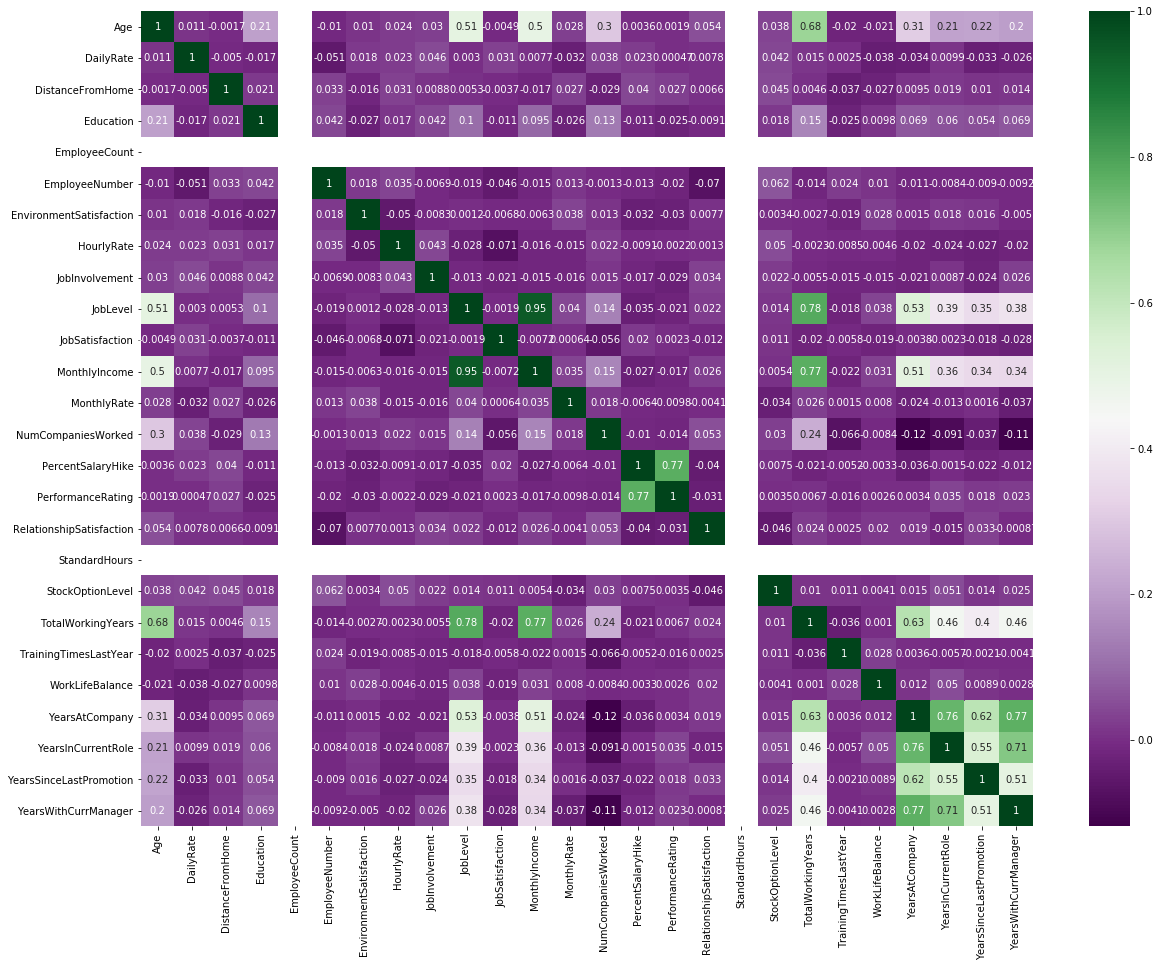

In [310]:
corrMatrix = hr.corr()
fig=plt.gcf()
fig.set_size_inches(20,15)
sns.heatmap(corrMatrix, annot = True, cmap = "PRGn")

We can see from the correlation matrix that there aren't very many highly correlated predictors in this dataset.

In [311]:
# Changing Attrition values from Yes and No to Quit and Not Quit to avoid confusion with another variable that has 
# Yes and No as values
# Then creating dummy variables for all categorical varibales with get_dummies
hr["Attrition"].replace({"Yes": "Quit", "No": "Not Quit"}, inplace=True)
hr_new = pd.get_dummies(hr, prefix='', prefix_sep='')


In [312]:
# splitting into training and testing sets
train = hr_new.sample(frac=0.5, random_state=10)
test = hr_new.drop(train.index)


In [313]:
# splitting features from label

train_data = train.drop(['Not Quit', 'Quit'], axis = 1)
test_data = test.drop(['Not Quit', 'Quit'], axis = 1)


train_labels = train.drop(['Age', 'DailyRate', 'DistanceFromHome', 'Education','EmployeeCount', 'EmployeeNumber', 
                           'EnvironmentSatisfaction','HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
                           'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked','PercentSalaryHike', 
                           'PerformanceRating','RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
                           'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance','YearsAtCompany', 
                           'YearsInCurrentRole', 'YearsSinceLastPromotion','YearsWithCurrManager','Non-Travel',
                           'Travel_Frequently', 'Travel_Rarely', 'Human Resources','Research & Development', 
                           'Sales', 'Human Resources','Life Sciences', 'Marketing', 'Medical', 'Other',
                           'Technical Degree', 'Female', 'Male', 'Healthcare Representative', 'Human Resources', 
                           'Laboratory Technician', 'Manager', 'Manufacturing Director', 'Research Director',
                           'Research Scientist', 'Sales Executive', 'Sales Representative',
                           'Divorced', 'Married', 'Single', 'Y', 'No', 'Yes'], axis = 1)

test_labels = test.drop(['Age', 'DailyRate', 'DistanceFromHome', 'Education','EmployeeCount', 'EmployeeNumber', 
                         'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
                         'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 
                         'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
                         'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance','YearsAtCompany',
                         'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager','Non-Travel',
                         'Travel_Frequently', 'Travel_Rarely', 'Human Resources','Research & Development', 'Sales', 
                         'Human Resources','Life Sciences', 'Marketing', 'Medical', 'Other','Technical Degree', 
                         'Female', 'Male', 'Healthcare Representative','Human Resources', 'Laboratory Technician',
                         'Manager','Manufacturing Director', 'Research Director','Research Scientist', 
                         'Sales Executive', 'Sales Representative','Divorced', 'Married', 'Single', 'Y', 
                         'No', 'Yes'], axis = 1)

train_data = train_data.values
test_data = test_data.values

train_labels = train_labels.values
test_labels = test_labels.values

In [314]:
# building the model
def build_model():
  model = keras.Sequential([
      layers.Dense(8, input_shape=(55,)),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Dropout(0.5),
      layers.Dense(4, activation = 'relu'),
      layers.Dense(2, activation='softmax')
  ])

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer='adam',
                metrics=['accuracy'])
  return model



In [315]:
model = build_model()


In [316]:
EPOCHS = 200

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, tfdocs.modeling.EpochDots()]) 


Epoch: 0, accuracy:0.3895,  loss:0.7683,  val_accuracy:0.2585,  val_loss:0.7614,  
....................................................................................................
Epoch: 100, accuracy:0.8214,  loss:0.5931,  val_accuracy:0.8231,  val_loss:0.5917,  
....................................................................................................

In [317]:
model.evaluate(test_data, test_labels, verbose = 2)

735/735 - 0s - loss: 0.5753 - accuracy: 0.8558


[0.5753174317126372, 0.85578233]

In [318]:
test_predictions = model.predict(test_data)

In [319]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_predictions,axis = 1)

# Convert validation observations to one hot vectors
#print(test_pred_classes)

# Convert validation observations to one hot vectors
test_true = np.argmax(test_labels,axis = 1)
#print(test_true)

# compute the confusion matrix
confusion_mtx = confusion_matrix(test_true, test_pred_classes)

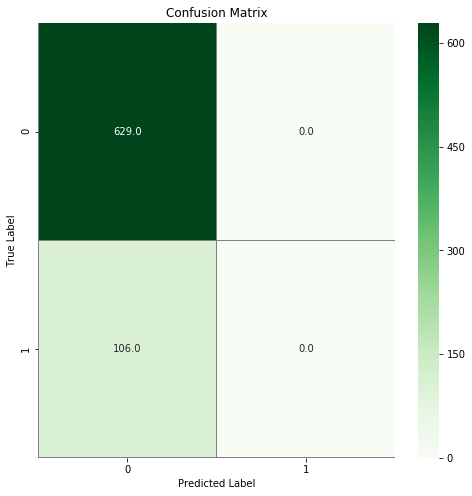

In [320]:
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Now I try oversampling the negative class in order to deal with the skewed data. Oversampling the minority class observations has become a common approach to improve the quality of predictive modeling. By oversampling, models are sometimes better able to learn patterns that differentiate classes.

https://beckernick.github.io/oversampling-modeling/

In [321]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [322]:
hr = pd.read_csv("/Users/dominicventura/Machine Learning/Neural Network Project/hremployee.csv")

In [323]:
from sklearn.preprocessing import LabelEncoder

for column in hr.columns:
    if hr[column].dtype == np.number:
        continue
    hr[column] = LabelEncoder().fit_transform(hr[column])

In [324]:
hr['Age_new'] = hr['Age']
hr = hr.drop('Age', axis = 1)

In [325]:
X = hr.drop(['Attrition'], axis = 1).values
y = hr['Attrition'].values

In [326]:
X_train, X_test, y_train, y_test = train_test_split(hr.drop(['Attrition'], axis = 1), hr['Attrition'], 
                                                                             test_size = 0.2, random_state=14)

In [327]:
sm = SMOTE(random_state=0, sampling_strategy = 1)

In [328]:
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [329]:
def build_model():
  model = keras.Sequential([
      layers.Dense(8, input_shape=(34,)),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Dense(4, activation = 'relu'),
      layers.Dropout(0.5),
      layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer='adam',
                metrics=['accuracy'])
  return model

In [330]:
model = build_model()

In [331]:
EPOCHS = 500

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  X_train_res, y_train_res,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, tfdocs.modeling.EpochDots()]) 


Epoch: 0, accuracy:0.5479,  loss:0.7793,  val_accuracy:0.1760,  val_loss:0.5508,  
...........

In [332]:
model.evaluate(X_test, y_test, verbose = 2)

294/294 - 0s - loss: 0.7277 - accuracy: 0.8639


[0.7277251591487807, 0.8639456]

In [333]:
test_predictions_sm = model.predict(X_test)

In [334]:
# Convert predictions classes to one hot vectors 
test_pred_classes_sm = np.argmax(test_predictions_sm,axis = 1)

# Convert validation observations to one hot vectors
#print(test_pred_classes)

# Convert validation observations to one hot vectors
test_true_sm = np.asarray(y_test)
#print(test_true)

# compute the confusion matrix
confusion_mtx_sm = confusion_matrix(test_true_sm, test_pred_classes_sm)

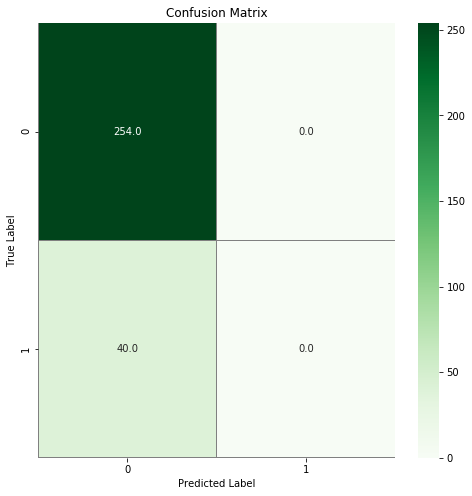

In [335]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx_sm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()